In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import pickle
import random
import tensorflow as tf
import os
import sys
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde, norm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from vae.vae import SVAE
from vae.train import train,train_new
from utils.data_processing import prep_data, make_tf_batches, seq_to_onehot
from vae.predict import predict
from utils.utils_f4f import heatmap, si_format
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'


#### Data_preparetion


In [6]:
# Import data 
assay = 'nor_package'
array = 'AA_sequence'

df_all = pd.read_csv('../data/2nd_10209_Package_aa.tsv',delimiter='\t')
df_all = df_all.rename(columns={'aa':'AA_sequence'})
df = df_all[['AA_sequence', 'nor_package']]
df= df.sort_values(by='nor_package')

#Fill in the nan data and replace the inf value
df['nor_package'] = df['nor_package'].fillna(0)  
df['nor_package'] = df['nor_package'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['nor_package','AA_sequence'])
# df = df.iloc[::50]
df

,AA_sequence,nor_package
6135,QGWFYLH,0.000000
2265,SGARVVG,0.000000
7430,KKCLPFA,0.000000
1321,RLHITVS,0.000000
3625,YIAFYLS,0.000000
...,...,...
8002,GRLVDQM,2.142577
4345,GRERGAL,2.154674
3823,SGTGGGG,2.164042
3541,KGKSLDD,2.188249


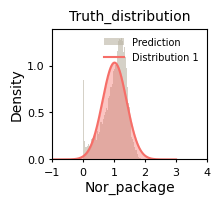

In [7]:
data = np.array(df_all['nor_package']) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-1, 3, 1000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Truth_distribution',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=8)
ax.set_xticks([-1, 0, 1,2,3,4]); 
ax.set_xlim([-1,4])
plt.ylabel('Density',labelpad=2,fontsize=10)
plt.xlabel('Nor_package',labelpad=2,fontsize=10)
plt.legend(fontsize=7,frameon=False,loc='best')
plt.show()

### Prep data and make Tensorflow-compatible data batches

`prep_data()` will one-hot encode the `AA_sequence` column and split the data into
training and test sets. The training split will be split
futher into training and validation batches with `make_tf_batches()`.


In [8]:
(data_list, train_df, test_df, prepped_df) = prep_data(df, AA_colname=array, target_assay_col=assay)
train_df['Y--nor_package'] = train_df['AA_sequence'].map(df.drop_duplicates('AA_sequence').set_index('AA_sequence')['nor_package'])
test_df['Y--nor_package'] = test_df['AA_sequence'].map(df.drop_duplicates('AA_sequence').set_index('AA_sequence')['nor_package'])
prepped_df['Y--nor_package'] = test_df['AA_sequence'].map(df.drop_duplicates('AA_sequence').set_index('AA_sequence')['nor_package'])

In [9]:
train_df.isnull().describe()
prepped_df.isnull().describe()

,AA_sequence,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x132,x133,x134,x135,x136,x137,x138,x139,Y--nor_package,test
count,10209,10209,10209,10209,10209,10209,10209,10209,10209,10209,...,10209,10209,10209,10209,10209,10209,10209,10209,10209,10209
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,2,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
freq,10209,10209,10209,10209,10209,10209,10209,10209,10209,10209,...,10209,10209,10209,10209,10209,10209,10209,10209,9189,10209


Now we split `train_df` into TensorFlow-compatible training and validation batches using
`make_tf_batches()`. `unbatched_data` is a tuple of Numpy arrays corresponding to the X, Y
and CV (if using) values across both the training and validation batches.


In [10]:
X, Y  = data_list
train_batches, val_batches, unbatched_data = make_tf_batches(X, Y)

## VAE  model training

Default parameterization:Here the model is applied to aa-nor_package learning process, as details

- `input_dim = 140`
- `latent_dim = 2`
- `enc_hidden_dims = [100,40]`
- `dec_hidden_dims = [40,100]`
- `reg_hidden_dims = [100,10]`


In [11]:
# SVAE parameters (same as default)
input_dim = 140
latent_dim = 2
enc_hidden_dims = [100,40]
dec_hidden_dims = [40,100]
reg_hidden_dims = [100,10]

# training parameters 

outpath = 'pretrain/vae/2nd_aa_nor_package'
loss_weights = [1.0,0.8,1.5] # [reconstruction, KL, regression]

initial_learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(initial_learning_rate)

# Initialize SVAE model (with default parameterizations)
model = SVAE(input_dim=140, latent_dim=2, enc_hidden_dims=[100,40], dec_hidden_dims=[40,100], reg_hidden_dims=[100,10], name='svae')
model.summary()

Model: "svae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 140)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  18304     ['encoder_input[0][0]',       
                              (None, 2),                             'encoder_input[0][0]']       
                              (None, 2)]                                                          
                                                                                                  
 tf.concat_1 (TFOpLambda)    (None, 142)                  0         ['encoder[1][0]',             
                                                                     'encoder_input[0][0]']    

The `train()` function returns the trained `model` and `preds_df`, a DataFrame of
regressor predictions on the X values in `unbatched_data`, along with their latent space
projections and their true Y values.

`train()` saves the trained model, as well as a log of the training and validation loss
values per epoch and `preds_df`, to disk. These saves will be made to an optional
parameter `model_outdir` - if not specified, `train()` will make a new,
informatively-named directory to write to (path is returned).

In [12]:
# Train model
model, preds_df, model_outdir = train_new(model, train_batches, val_batches, array,outpath,
                                        train_df, optimizer=optimizer,                    
                                        loss_weights=loss_weights           
                        )

Logging following metrics: ['train_model_loss', 'train_reconstruction_loss', 'train_kl_loss', 'train_regression_loss', 'val_model_loss', 'val_reconstruction_loss', 'val_kl_loss', 'val_regression_loss']


----- Beginning training. -----

epoch 1
4087/4087 [==============================] - 33s 8ms/step - train_model_loss: 19.6810 - train_reconstruction_loss: 19.5146 - train_kl_loss: 0.0060 - train_regression_loss: 0.1078 - val_model_loss: 19.4736 - val_reconstruction_loss: 19.3448 - val_kl_loss: 0.0020 - val_regression_loss: 0.0847
INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 2
4087/4087 [==============================] - 33s 8ms/step - train_model_loss: 19.4841 - train_reconstruction_loss: 19.3668 - train_kl_loss: 0.0012 - train_regression_loss: 0.0775 - val_model_loss: 19.4784 - val_reconstruction_loss: 19.3672 - val_kl_loss: 0.0013 - val_regression_loss: 0.0735


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 3
4087/4087 [==============================] - 33s 8ms/step - train_model_loss: 19.4572 - train_reconstruction_loss: 19.3526 - train_kl_loss: 6.7342e-04 - train_regression_loss: 0.0693 - val_model_loss: 19.4365 - val_reconstruction_loss: 19.3411 - val_kl_loss: 2.4696e-04 - val_regression_loss: 0.0634


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 4
4087/4087 [==============================] - 33s 8ms/step - train_model_loss: 19.4451 - train_reconstruction_loss: 19.3562 - train_kl_loss: 3.0602e-04 - train_regression_loss: 0.0590 - val_model_loss: 19.3828 - val_reconstruction_loss: 19.2957 - val_kl_loss: 1.2103e-04 - val_regression_loss: 0.0580


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 5
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.4302 - train_reconstruction_loss: 19.3480 - train_kl_loss: 3.0641e-04 - train_regression_loss: 0.0549 - val_model_loss: 19.4078 - val_reconstruction_loss: 19.3270 - val_kl_loss: 2.1943e-04 - val_regression_loss: 0.0538


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 6
4087/4087 [==============================] - 35s 9ms/step - train_model_loss: 19.4342 - train_reconstruction_loss: 19.3561 - train_kl_loss: 3.0630e-04 - train_regression_loss: 0.0518 - val_model_loss: 19.4151 - val_reconstruction_loss: 19.3385 - val_kl_loss: 2.3776e-04 - val_regression_loss: 0.0509


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 7
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.4286 - train_reconstruction_loss: 19.3531 - train_kl_loss: 2.7222e-04 - train_regression_loss: 0.0502 - val_model_loss: 19.4282 - val_reconstruction_loss: 19.3569 - val_kl_loss: 2.2171e-04 - val_regression_loss: 0.0474


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 8
4087/4087 [==============================] - 33s 8ms/step - train_model_loss: 19.4063 - train_reconstruction_loss: 19.3315 - train_kl_loss: 2.7039e-04 - train_regression_loss: 0.0497 - val_model_loss: 19.4353 - val_reconstruction_loss: 19.3747 - val_kl_loss: 2.3325e-04 - val_regression_loss: 0.0402


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 9
4087/4087 [==============================] - 33s 8ms/step - train_model_loss: 19.4206 - train_reconstruction_loss: 19.3497 - train_kl_loss: 3.1780e-04 - train_regression_loss: 0.0471 - val_model_loss: 19.4322 - val_reconstruction_loss: 19.3688 - val_kl_loss: 3.1790e-04 - val_regression_loss: 0.0422


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 10
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.4115 - train_reconstruction_loss: 19.3421 - train_kl_loss: 3.1925e-04 - train_regression_loss: 0.0461 - val_model_loss: 19.4388 - val_reconstruction_loss: 19.3775 - val_kl_loss: 4.3218e-04 - val_regression_loss: 0.0407


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 11
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.4196 - train_reconstruction_loss: 19.3549 - train_kl_loss: 2.6130e-04 - train_regression_loss: 0.0429 - val_model_loss: 19.3691 - val_reconstruction_loss: 19.3085 - val_kl_loss: 2.6769e-04 - val_regression_loss: 0.0403


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 12
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.4013 - train_reconstruction_loss: 19.3361 - train_kl_loss: 3.0741e-04 - train_regression_loss: 0.0434 - val_model_loss: 19.4053 - val_reconstruction_loss: 19.3464 - val_kl_loss: 0.0012 - val_regression_loss: 0.0386


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 13
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.4064 - train_reconstruction_loss: 19.3434 - train_kl_loss: 3.9367e-04 - train_regression_loss: 0.0417 - val_model_loss: 19.3883 - val_reconstruction_loss: 19.3306 - val_kl_loss: 2.9469e-04 - val_regression_loss: 0.0383


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 14
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.3893 - train_reconstruction_loss: 19.3285 - train_kl_loss: 4.1437e-04 - train_regression_loss: 0.0403 - val_model_loss: 19.3592 - val_reconstruction_loss: 19.3042 - val_kl_loss: 2.6402e-04 - val_regression_loss: 0.0365


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 15
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.4064 - train_reconstruction_loss: 19.3481 - train_kl_loss: 2.8190e-04 - train_regression_loss: 0.0387 - val_model_loss: 19.3894 - val_reconstruction_loss: 19.3349 - val_kl_loss: 0.0012 - val_regression_loss: 0.0357


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 16
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.4024 - train_reconstruction_loss: 19.3453 - train_kl_loss: 4.9220e-04 - train_regression_loss: 0.0379 - val_model_loss: 19.4154 - val_reconstruction_loss: 19.3610 - val_kl_loss: 3.9048e-04 - val_regression_loss: 0.0361


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 17
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.3970 - train_reconstruction_loss: 19.3420 - train_kl_loss: 3.4333e-04 - train_regression_loss: 0.0365 - val_model_loss: 19.3842 - val_reconstruction_loss: 19.3377 - val_kl_loss: 2.9478e-04 - val_regression_loss: 0.0308


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 18
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.3746 - train_reconstruction_loss: 19.3210 - train_kl_loss: 3.0866e-04 - train_regression_loss: 0.0358 - val_model_loss: 19.4043 - val_reconstruction_loss: 19.3489 - val_kl_loss: 4.0574e-04 - val_regression_loss: 0.0367


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 19
4087/4087 [==============================] - 33s 8ms/step - train_model_loss: 19.3774 - train_reconstruction_loss: 19.3246 - train_kl_loss: 5.8472e-04 - train_regression_loss: 0.0349 - val_model_loss: 19.3676 - val_reconstruction_loss: 19.3180 - val_kl_loss: 0.0010 - val_regression_loss: 0.0326


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 20
4087/4087 [==============================] - 33s 8ms/step - train_model_loss: 19.3923 - train_reconstruction_loss: 19.3415 - train_kl_loss: 5.5107e-04 - train_regression_loss: 0.0335 - val_model_loss: 19.4080 - val_reconstruction_loss: 19.3647 - val_kl_loss: 6.8434e-04 - val_regression_loss: 0.0285


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 21
4087/4087 [==============================] - 33s 8ms/step - train_model_loss: 19.3887 - train_reconstruction_loss: 19.3413 - train_kl_loss: 4.9630e-04 - train_regression_loss: 0.0314 - val_model_loss: 19.3726 - val_reconstruction_loss: 19.3306 - val_kl_loss: 5.0220e-04 - val_regression_loss: 0.0277


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 22
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.3842 - train_reconstruction_loss: 19.3360 - train_kl_loss: 4.5376e-04 - train_regression_loss: 0.0319 - val_model_loss: 19.3992 - val_reconstruction_loss: 19.3580 - val_kl_loss: 4.2303e-04 - val_regression_loss: 0.0272


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 23
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.3883 - train_reconstruction_loss: 19.3433 - train_kl_loss: 5.4103e-04 - train_regression_loss: 0.0297 - val_model_loss: 19.4127 - val_reconstruction_loss: 19.3710 - val_kl_loss: 2.8622e-04 - val_regression_loss: 0.0277


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 24
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.3788 - train_reconstruction_loss: 19.3351 - train_kl_loss: 6.4466e-04 - train_regression_loss: 0.0288 - val_model_loss: 19.3786 - val_reconstruction_loss: 19.3420 - val_kl_loss: 4.4171e-04 - val_regression_loss: 0.0242


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 25
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.3824 - train_reconstruction_loss: 19.3413 - train_kl_loss: 6.3442e-04 - train_regression_loss: 0.0270 - val_model_loss: 19.3683 - val_reconstruction_loss: 19.3306 - val_kl_loss: 2.5437e-04 - val_regression_loss: 0.0250


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 26
4087/4087 [==============================] - 33s 8ms/step - train_model_loss: 19.3719 - train_reconstruction_loss: 19.3322 - train_kl_loss: 4.8196e-04 - train_regression_loss: 0.0262 - val_model_loss: 19.4058 - val_reconstruction_loss: 19.3718 - val_kl_loss: 4.7010e-04 - val_regression_loss: 0.0224


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 27
4087/4087 [==============================] - 33s 8ms/step - train_model_loss: 19.3729 - train_reconstruction_loss: 19.3327 - train_kl_loss: 5.9517e-04 - train_regression_loss: 0.0264 - val_model_loss: 19.3174 - val_reconstruction_loss: 19.2837 - val_kl_loss: 3.2740e-04 - val_regression_loss: 0.0223


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 28
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.3686 - train_reconstruction_loss: 19.3299 - train_kl_loss: 6.3619e-04 - train_regression_loss: 0.0255 - val_model_loss: 19.2852 - val_reconstruction_loss: 19.2520 - val_kl_loss: 0.0011 - val_regression_loss: 0.0216


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 29
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.3789 - train_reconstruction_loss: 19.3424 - train_kl_loss: 5.6875e-04 - train_regression_loss: 0.0241 - val_model_loss: 19.3177 - val_reconstruction_loss: 19.2822 - val_kl_loss: 2.8707e-04 - val_regression_loss: 0.0235


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 30
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.3637 - train_reconstruction_loss: 19.3284 - train_kl_loss: 3.5016e-04 - train_regression_loss: 0.0233 - val_model_loss: 19.3561 - val_reconstruction_loss: 19.3226 - val_kl_loss: 2.9949e-04 - val_regression_loss: 0.0222


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.
Convergence history: [1]

epoch 31
4087/4087 [==============================] - 35s 9ms/step - train_model_loss: 19.3793 - train_reconstruction_loss: 19.3441 - train_kl_loss: 5.8074e-04 - train_regression_loss: 0.0232 - val_model_loss: 19.4546 - val_reconstruction_loss: 19.4247 - val_kl_loss: 7.0735e-04 - val_regression_loss: 0.0196


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.
Convergence history: [1, 0]

epoch 32
4087/4087 [==============================] - 35s 9ms/step - train_model_loss: 19.3718 - train_reconstruction_loss: 19.3387 - train_kl_loss: 5.8420e-04 - train_regression_loss: 0.0217 - val_model_loss: 19.3339 - val_reconstruction_loss: 19.3064 - val_kl_loss: 5.7930e-04 - val_regression_loss: 0.0180


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.
Convergence history: [1, 0, 1]

epoch 33
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.3654 - train_reconstruction_loss: 19.3323 - train_kl_loss: 6.0582e-04 - train_regression_loss: 0.0218 - val_model_loss: 19.4264 - val_reconstruction_loss: 19.3914 - val_kl_loss: 1.2241e-04 - val_regression_loss: 0.0233


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.
Convergence history: [1, 0, 1, 1]

epoch 34
4087/4087 [==============================] - 35s 9ms/step - train_model_loss: 19.3664 - train_reconstruction_loss: 19.3340 - train_kl_loss: 6.3586e-04 - train_regression_loss: 0.0213 - val_model_loss: 19.4102 - val_reconstruction_loss: 19.3755 - val_kl_loss: 0.0013 - val_regression_loss: 0.0225


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.
Convergence history: [1, 0, 1, 1, 1]

epoch 35
Converged. Stall: 1/10
4087/4087 [==============================] - 36s 9ms/step - train_model_loss: 19.3700 - train_reconstruction_loss: 19.3386 - train_kl_loss: 6.0810e-04 - train_regression_loss: 0.0207 - val_model_loss: 19.3384 - val_reconstruction_loss: 19.3108 - val_kl_loss: 6.3339e-04 - val_regression_loss: 0.0180


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 36
Converged. Stall: 2/10
4087/4087 [==============================] - 35s 9ms/step - train_model_loss: 19.3726 - train_reconstruction_loss: 19.3428 - train_kl_loss: 4.9114e-04 - train_regression_loss: 0.0197 - val_model_loss: 19.3525 - val_reconstruction_loss: 19.3253 - val_kl_loss: 2.0250e-04 - val_regression_loss: 0.0180


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 37
Converged. Stall: 3/10
4087/4087 [==============================] - 34s 8ms/step - train_model_loss: 19.3599 - train_reconstruction_loss: 19.3317 - train_kl_loss: 6.5143e-04 - train_regression_loss: 0.0184 - val_model_loss: 19.2600 - val_reconstruction_loss: 19.2327 - val_kl_loss: 8.9994e-04 - val_regression_loss: 0.0178


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 38
Converged. Stall: 4/10
4087/4087 [==============================] - 33s 8ms/step - train_model_loss: 19.3545 - train_reconstruction_loss: 19.3275 - train_kl_loss: 6.6924e-04 - train_regression_loss: 0.0176 - val_model_loss: 19.3356 - val_reconstruction_loss: 19.3113 - val_kl_loss: 6.3985e-04 - val_regression_loss: 0.0160


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 39
Converged. Stall: 5/10
4087/4087 [==============================] - 33s 8ms/step - train_model_loss: 19.3537 - train_reconstruction_loss: 19.3273 - train_kl_loss: 6.8351e-04 - train_regression_loss: 0.0172 - val_model_loss: 19.3996 - val_reconstruction_loss: 19.3742 - val_kl_loss: 4.4727e-04 - val_regression_loss: 0.0167


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.

epoch 40
Converged. Stall: 6/10
4087/4087 [==============================] - 33s 8ms/step - train_model_loss: 19.3511 - train_reconstruction_loss: 19.3257 - train_kl_loss: 4.6814e-04 - train_regression_loss: 0.0167 - val_model_loss: 19.3140 - val_reconstruction_loss: 19.2914 - val_kl_loss: 3.0245e-04 - val_regression_loss: 0.0150


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


INFO:tensorflow:Assets written to: pretrain/vae/2nd_aa_nor_package\assets


Model saved to pretrain/vae/2nd_aa_nor_package.
Hit maximum epochs.
Finished training model. Final overall losses:
train: 19.351    val:19.314
288/288 [==============================] - 0s 653us/step

MSE of predictions vs true labels: 0.015252804383635521


INFO:tensorflow:Assets written to: e:\Elite\Now_repority\20240220\trained_models\2024420_nor_package_2D_40epochs_19.35T_19.31V\model\assets


INFO:tensorflow:Assets written to: e:\Elite\Now_repority\20240220\trained_models\2024420_nor_package_2D_40epochs_19.35T_19.31V\model\assets


Model saved to e:\Elite\Now_repority\20240220\trained_models\2024420_nor_package_2D_40epochs_19.35T_19.31V\model.
Losses saved to e:\Elite\Now_repority\20240220\trained_models\2024420_nor_package_2D_40epochs_19.35T_19.31V\loss_log.csv.
Train predictions saved to e:\Elite\Now_repority\20240220\trained_models\2024420_nor_package_2D_40epochs_19.35T_19.31V\preds.csv.


####  Correlation between result and prediction 

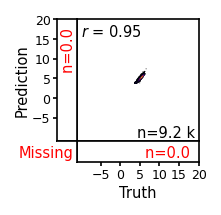

In [15]:


x = preds_df['y_pred']
y = preds_df['y_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=100, random_state=1), 
    y_both.sample(n=100, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))


fig = plt.figure(figsize=(1.4,1.3), dpi=150)

gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.2f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10, 15,20])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10, 15,20]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)


# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
fig.savefig('../results/vae/2nd_results/nor_package/2nd_vae_aa_nor_package_correlation_train.pdf',dpi=300,bbox_inches='tight')

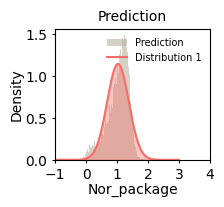

In [16]:

data = np.array(preds_df['y_pred']) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-5, 3, 1000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-1, 0, 1,2,3,4]); 
ax.set_xlim([-1,4])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
plt.show()
fig.savefig('../results/vae/2nd_results/nor_package/2nd_vae_nor_package_distribution_train.pdf',dpi=300,bbox_inches='tight')

In [17]:
AA = test_df[array].values
X = test_df.drop(columns=[array,'Y--nor_package'])
Y = test_df['Y--nor_package'].values
preds_df = predict(model, X,array, Y=Y, AA=AA)
preds_df['y_pred'].corr(preds_df['y_true'])

32/32 [==============================] - 0s 537us/step

MSE of predictions vs true labels: 0.013774584978818893


0.9530633588986005

d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


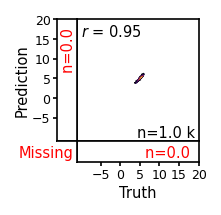

In [18]:


x = preds_df['y_pred']
y = preds_df['y_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=100, random_state=1), 
    y_both.sample(n=100, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))


fig = plt.figure(figsize=(1.4,1.3), dpi=150)

gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=0.2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.2f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10, 15,20])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10, 15,20]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2,fontsize=7)
ax.tick_params(axis='both', labelsize=6, length=2, pad=1)


# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
fig.savefig('../results/vae/2nd_results/nor_package/2nd_vae_aa_nor_package_correlation_test.pdf',dpi=300,bbox_inches='tight')

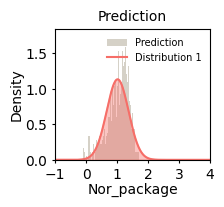

In [19]:

data = np.array(preds_df['y_pred']) 
data = data.reshape(-1, 1)  # Convert the data into a column vector

# Fit the data using GaussianMixture
n_components = 1 # Set the number of components for the hybrid model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(data)

# Get the mean and covariance matrix for each component
means = gmm.means_
covariances = gmm.covariances_

# Generate the fitted distribution
x = np.linspace(-10, 8, 1000)
x = x.reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# Plot the raw data and the distribution after fitting
plt.hist(data, bins=100, density=True, alpha=0.6, color = '#BAB3A3',label='Prediction')

# 绘制每个分量的正态分布
for i in range(n_components):
    component = np.exp(-(x - means[i]) ** 2 / (2 * covariances[i]))
    component /= np.sqrt(2 * np.pi * covariances[i])
    component *= gmm.weights_[i]
    if i == 0:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#F66E68', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#F66E68', alpha=0.4)
    else:
        ax.plot(x, component, '-', label=f'Distribution {i + 1}', color='#457B9D', alpha=1)
        ax.fill_between(x.flatten(), 0, component.flatten(), color='#457B9D', alpha=0.4)


plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-1, 0, 1,2,3,4]); 
ax.set_xlim([-1,4])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
plt.show()
fig.savefig('../results/vae/2nd_results/nor_package/2nd_vae_nor_package_distribution_test.pdf',dpi=300,bbox_inches='tight')